## Importing the relevant packages

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2
from math import sqrt
import seaborn as sns
sns.set()

In [13]:
import warnings
warnings.filterwarnings("ignore")

## Importing the Data and Pre-processing

In [8]:
raw_csv_data = pd.read_csv("INDEX2023.csv")
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [9]:
df_comp

,spx,dax,ftse,nikkei
date,,,,
1994-01-10,475.269989,2225.000000,3440.600098,18443.439453
1994-01-11,474.130005,2228.100098,3413.800049,18485.250000
1994-01-12,474.170013,2182.060059,3372.000000,18793.880859
1994-01-13,472.470001,2142.370117,3360.000000,18577.259766
1994-01-14,474.910004,2151.050049,3400.600098,18973.699219
...,...,...,...,...
2023-07-24,4554.640137,16190.950195,7678.600098,32700.939453
2023-07-25,4567.459961,16211.589844,7691.799805,32682.509766
2023-07-26,4566.750000,16131.459961,7676.899902,32668.339844


In [10]:
df_comp['market_value']=df_comp.ftse

In [11]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
# seleccionando data trian y data test
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## The LLR Test

In [14]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

## Creating Returns

In [15]:
# para series no estacionarias
df['returns'] = df.market_value.pct_change(1)*100

## Creating Squared Returns (retornos al cuadrado)

In [17]:
df['sq_returns'] = df.returns.mul(df.returns)

In [20]:
df

,market_value,returns,sq_returns
date,,,
1994-01-10,3440.600098,NaN,NaN
1994-01-11,3413.800049,-0.778935,0.606740
1994-01-12,3372.000000,-1.224443,1.499262
1994-01-13,3360.000000,-0.355872,0.126645
1994-01-14,3400.600098,1.208336,1.460076
...,...,...,...
2017-08-24,7407.100098,0.330501,0.109231
2017-08-25,7401.500000,-0.075604,0.005716
2017-08-28,7401.500000,0.000000,0.000000


## Returns vs Squared Returns

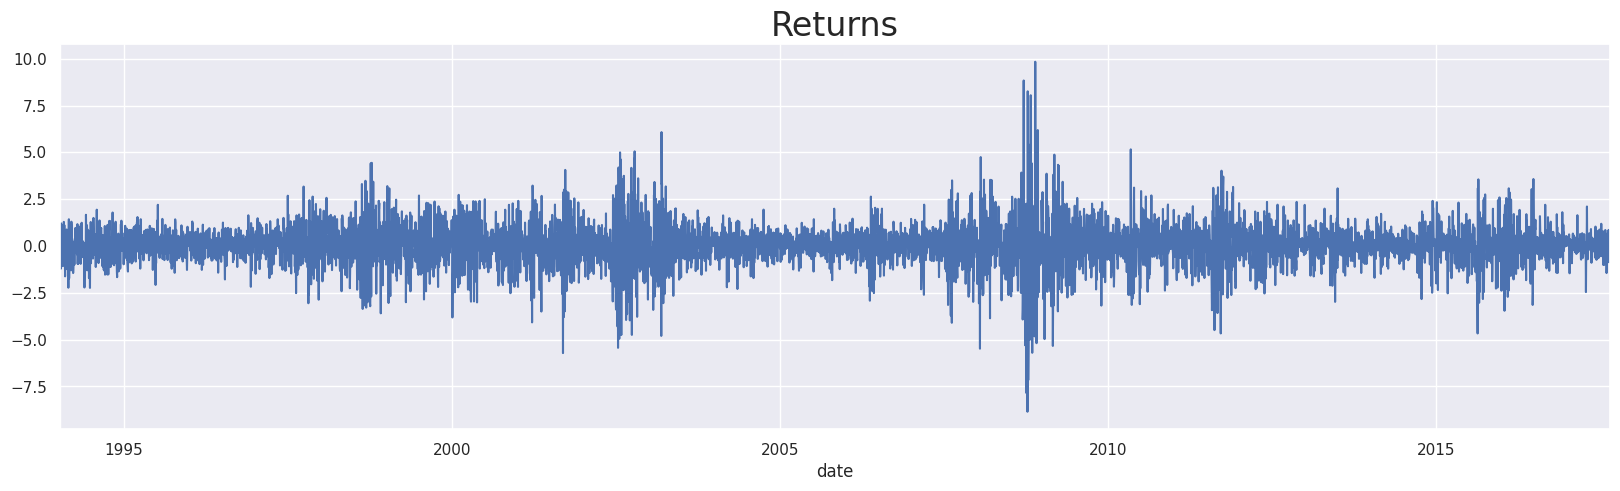

In [18]:
# retornos
df.returns.plot(figsize=(20,5))
plt.title("Returns", size = 24)
plt.show()

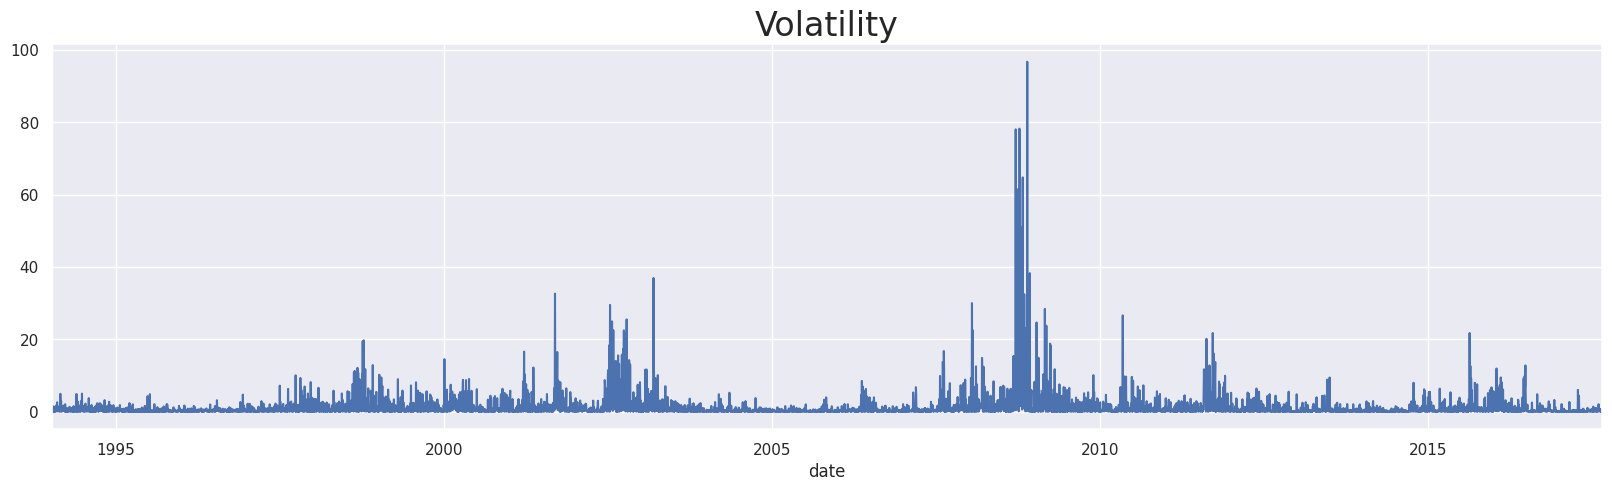

In [19]:
# retornos al cuadrado
df.sq_returns.plot(figsize=(20,5))
plt.title("Volatility", size = 24)
plt.show()

mide la volatilidad. existe saltos de mayor magnitud.

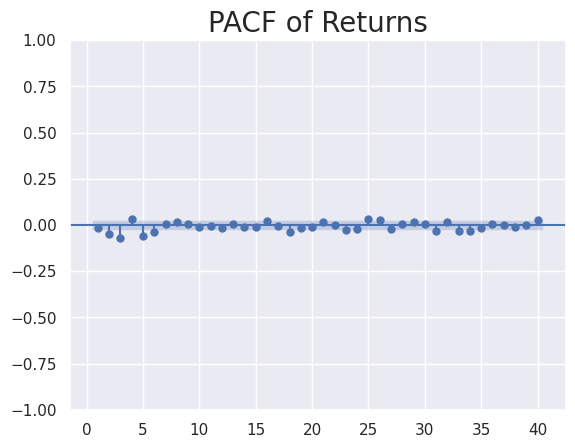

In [ ]:
# PACF para retornos
sgt.plot_pacf(df.returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Returns", size = 20)
plt.show()

Regla: la regla dicta que si la serie temporal se asemeja a ruido blanco y su version cuadrada, sugiere usar un modelo autorregresivo n, debemos recurrir al uso de un modelo ARCH para modelar la varianza.

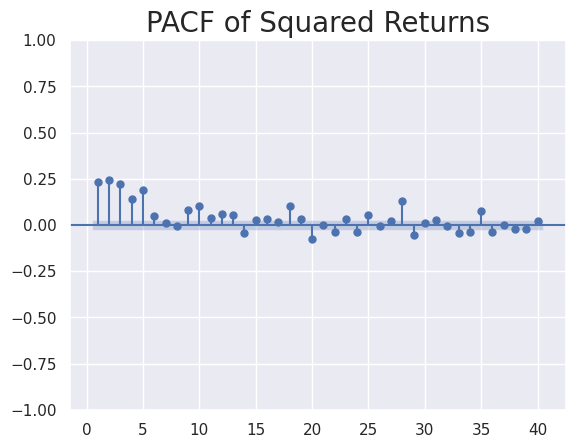

In [21]:
# FACP para retornos al cuadrado (autocorrelacion parcial)
sgt.plot_pacf(df.sq_returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Squared Returns", size = 20)
plt.show()

Los primeros 6 retrasos son significativos y vemos muchos puntos con valores significativos entre 0.15 hasta 0.25 mas o menes, esto indicaria tendencias a corto plazo en la varianza.  

## The arch_model() Method

In [22]:
# instalando la libreria arch
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 7.5 MB/s eta 0:00:00


In [23]:
from arch import arch_model

In [24]:
# ARCH (1) de orden 1
model_arch_1 = arch_model(df.returns[1:])
results_arch_1 = model_arch_1.fit()
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 285244856487503.7
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1686679317.021001
Iteration:      3,   Func. Count:     23,   Neg. LLF: 8390.849134146418
Iteration:      4,   Func. Count:     29,   Neg. LLF: 8418.426409732092
Iteration:      5,   Func. Count:     35,   Neg. LLF: 8341.36952024206
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8773.293290953878
Iteration:      7,   Func. Count:     48,   Neg. LLF: 8337.29527917222
Iteration:      8,   Func. Count:     54,   Neg. LLF: 8333.121263546764
Iteration:      9,   Func. Count:     60,   Neg. LLF: 8333.064384758072
Iteration:     10,   Func. Count:     65,   Neg. LLF: 8333.064383147337
Iteration:     11,   Func. Count:     69,   Neg. LLF: 8333.06438314709
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8333.064383147337
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations: 11
It

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8333.06
Distribution:                  Normal   AIC:                           16674.1
Method:            Maximum Likelihood   BIC:                           16701.0
                                        No. Observations:                 6167
Date:                Sat, Sep 02 2023   Df Residuals:                     6166
Time:                        14:59:59   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0427  1.053e-02      4.052  5.068e-05 [2.203e-02,6.329e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0135  3.482e-03      3.874  1.069e-04 [6.665e-03,2.031e-02]
alpha[1]       0.0891  1.150e-02      7.751  9.086e-15   [6.660e-02,  0.112]
beta[1]        0.8998  1.300e-02     69.226      0.000     [  0.874,  0.925]
============================================================================

Covariance estimator: robust
"""

El coeficiente que representa a la media es significativa, asi como omega que representa el valor constante. al observar alpha[1], tambein es significativa. (beta [1] se leera en los modelos GARCH)

Este modelo necesita de varias iteraciones porque tiene que ajustar dos acuaciones al mismo tiempo, es decir, primero se ajusta un modelo con cierto coeficiente, luego verifica que tan bien se ha realizado ese ajuste, luego se reajusta todo antes de hacer una verificacion secundaria y asi sucesivamente...el programa se detiene cuando la verosimilitud es lo suficientemente alta, esto lo hace automaticamente.

La ecuacion de la media supone que la media no esta correlacionada en serie, es decir, es invariante en el tiempo, por lo que no incluyen valores pasados ni residuos pasados, por lo tanto, debemos usar la media constante predeterminada o la mas especifica de igual a cero.
## The Simple ARCH(1)

In [25]:
# ARCH(1)
model_arch_1 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 1)
results_arch_1 = model_arch_1.fit(update_freq = 1)
results_arch_1.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 37547.0799093121
Iteration:      2,   Func. Count:     13,   Neg. LLF: 14319.86123615623
Iteration:      3,   Func. Count:     20,   Neg. LLF: 9311.858080688677
Iteration:      4,   Func. Count:     26,   Neg. LLF: 9129.053292920526
Iteration:      5,   Func. Count:     30,   Neg. LLF: 9129.053274194035
Iteration:      6,   Func. Count:     33,   Neg. LLF: 9129.053274194113
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9129.053274194035
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9129.05
Distribution:                  Normal   AIC:                           18264.1
Method:            Maximum Likelihood   BIC:                           18284.3
                                        No. Observations:                 6167
Date:                Sat, Sep 02 2023   Df Residuals:                     6166
Time:                        15:06:35   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0344  1.387e-02      2.481  1.311e-02 [7.226e-03,6.161e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.8352  3.539e-02     23.601 3.741e-123 [  0.766,  0.905]
alpha[1]       0.3755  4.551e-02      8.251  1.577e-16 [  0.286,  0.465]
========================================================================

Covariance estimator: robust
"""

El modelo ARCH simple es el mejor modelo entre AR, MA e incluso ARIMA porque tiene una verosimilitud alta y AIC baja.

Es muy importante recordar que este modelo solo se utiliza para predecir variaciones futuras en lugar de rendimientos futuros.

## Higher-Lag ARCH Models

In [26]:
# ARCH(2), orden 2.
model_arch_2 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 2)
results_arch_2 = model_arch_2.fit(update_freq = 5)
results_arch_2.summary()

Iteration:      5,   Func. Count:     39,   Neg. LLF: 8884.290384226128
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8884.286248349448
            Iterations: 7
            Function evaluations: 49
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8884.29
Distribution:                  Normal   AIC:                           17776.6
Method:            Maximum Likelihood   BIC:                           17803.5
                                        No. Observations:                 6167
Date:                Sat, Sep 02 2023   Df Residuals:                     6166
Time:                        15:09:17   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0419  1.208e-02      3.473  5.151e-04 [1.827e-02,6.562e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6389  2.984e-02     21.414 9.839e-102 [  0.580,  0.697]
alpha[1]       0.2327  3.211e-02      7.247  4.264e-13 [  0.170,  0.296]
alpha[2]       0.2674  3.221e-02      8.303  1.019e-16 [  0.204,  0.331]
========================================================================

Covariance estimator: robust
"""

La verosimilitud aumenta y el AIC disminuye, sugiere que el ARCH 2 es mejor que el ARCH 1, pero tenemos que verificar los coeficientes. todos son significativos?, al observar que si.... el modelo ARCH(2) es mejor que el modelo ARC(1).

In [27]:
# ARCH(3)
model_arch_3 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 3)
results_arch_3 = model_arch_3.fit(update_freq = 5)
results_arch_3.summary()

Iteration:      5,   Func. Count:     41,   Neg. LLF: 9228.524926859465
Iteration:     10,   Func. Count:     75,   Neg. LLF: 8672.606558904958
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8672.606558904958
            Iterations: 11
            Function evaluations: 80
            Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8672.61
Distribution:                  Normal   AIC:                           17355.2
Method:            Maximum Likelihood   BIC:                           17388.8
                                        No. Observations:                 6167
Date:                Sat, Sep 02 2023   Df Residuals:                     6166
Time:                        15:11:03   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0472  1.145e-02      4.120  3.786e-05 [2.474e-02,6.963e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.4661  2.343e-02     19.892  4.765e-88 [  0.420,  0.512]
alpha[1]       0.1635  2.428e-02      6.731  1.684e-11 [  0.116,  0.211]
alpha[2]       0.2066  2.276e-02      9.075  1.141e-19 [  0.162,  0.251]
alpha[3]       0.2765  2.979e-02      9.282  1.665e-20 [  0.218,  0.335]
========================================================================

Covariance estimator: robust
"""

sigue mejorando.

veamos el 13. uno deja de ser significativo..

In [28]:
model_arch_13 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 13)
results_arch_13 = model_arch_13.fit(update_freq = 5)
results_arch_13.summary()

Iteration:      5,   Func. Count:     91,   Neg. LLF: 10664.053482136987
Iteration:     10,   Func. Count:    181,   Neg. LLF: 10014.182137836997
Iteration:     15,   Func. Count:    269,   Neg. LLF: 8622.942996261836
Iteration:     20,   Func. Count:    356,   Neg. LLF: 8518.095671851372
Iteration:     25,   Func. Count:    446,   Neg. LLF: 8347.653682487
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8347.642583058805
            Iterations: 29
            Function evaluations: 510
            Gradient evaluations: 29


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8347.64
Distribution:                  Normal   AIC:                           16725.3
Method:            Maximum Likelihood   BIC:                           16826.2
                                        No. Observations:                 6167
Date:                Sat, Sep 02 2023   Df Residuals:                     6166
Time:                        15:11:54   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0460  1.063e-02      4.329  1.498e-05 [2.517e-02,6.683e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1940  2.001e-02      9.698  3.072e-22      [  0.155,  0.233]
alpha[1]       0.0698  1.709e-02      4.086  4.386e-05    [3.633e-02,  0.103]
alpha[2]       0.1089  1.803e-02      6.041  1.527e-09    [7.357e-02,  0.144]
alpha[3]       0.1323  2.299e-02      5.755  8.672e-09    [8.725e-02,  0.177]
alpha[4]       0.0904  1.845e-02      4.897  9.741e-07    [5.419e-02,  0.127]
alpha[5]       0.0698  1.641e-02      4.255  2.095e-05    [3.765e-02,  0.102]
alpha[6]       0.0795  1.666e-02      4.774  1.807e-06    [4.688e-02,  0.112]
alpha[7]       0.0409  1.719e-02      2.378  1.743e-02  [7.180e-03,7.458e-02]
alpha[8]       0.0644  1.641e-02      3.922  8.777e-05  [3.221e-02,9.655e-02]
alpha[9]       0.0274  1.453e-02      1.886  5.933e-02 [-1.079e-03,5.587e-02]
alpha[10]      0.0291  1.440e-02      2.023  4.303e-02  [9.136e-04,5.736e-02]
alpha[11]      0.0656  1.624e-02      4.036  5.426e-05  [3.373e-02,9.740e-02]
alpha[12]      0.0483  1.624e-02      2.976  2.925e-03  [1.650e-02,8.017e-02]
alpha[13]      0.0223  1.222e-02      1.829  6.746e-02 [-1.605e-03,4.630e-02]
=============================================================================

Covariance estimator: robust
"""

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,15))
ar_orders=[1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] # lags
fitted_model_dict={}
for idx, ar_order in enumerate (ar_orders):
  model_arch = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p=(ar_order))
  results_arch = model_arch.fit(update_freq = 1)
  fitted_model_dict[ar_order]=results_arch
  #plt.subplot(7,1,idx+1)
  #plt.plot(df_training.market_value)
  #plt.plot(ar_model_fit.fittedvalues)
plt.tight_layout()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 37547.0799093121
Iteration:      2,   Func. Count:     13,   Neg. LLF: 14319.86123615623
Iteration:      3,   Func. Count:     20,   Neg. LLF: 9311.858080688677
Iteration:      4,   Func. Count:     26,   Neg. LLF: 9129.053292920526
Iteration:      5,   Func. Count:     30,   Neg. LLF: 9129.053274194035
Iteration:      6,   Func. Count:     33,   Neg. LLF: 9129.053274194113
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9129.053274194035
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      7,   Neg. LLF: 50898.798807980886
Iteration:      2,   Func. Count:     18,   Neg. LLF: 14323.983557058895
Iteration:      3,   Func. Count:     27,   Neg. LLF: 9881.787557886257
Iteration:      4,   Func. Count:     34,   Neg. LLF: 9243.161055217985
Iteration:      5,   Func. Count:     41,   Neg. LLF: 9228.524926859465


<Figure size 1200x1500 with 0 Axes>

In [38]:
#resultados AIC
for ar_order in ar_orders:
  print("AIC for AR(%s): %s" %(ar_order,fitted_model_dict[ar_order].aic))

AIC for AR(1): 18264.10654838807
AIC for AR(3): 17355.213117809915
AIC for AR(4): 17138.599812985645
AIC for AR(5): 16984.013699804298
AIC for AR(6): 16875.591395380798
AIC for AR(7): 16841.226338953034
AIC for AR(8): 16801.067779673158
AIC for AR(9): 16789.562765164992
AIC for AR(10): 16773.674564505713
AIC for AR(11): 16743.135711365103
AIC for AR(12): 16727.538472370783
AIC for AR(13): 16725.28516611761
AIC for AR(14): 16725.907667612802
AIC for AR(15): 16721.18989680525
AIC for AR(16): 16716.55196966492
AIC for AR(17): 16718.363868838802
AIC for AR(18): 16713.76863098961
AIC for AR(19): 16713.257319880093
AIC for AR(20): 16715.07315179401


verificar la significancia de los parametros

In [40]:
model_arch_19 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 19)
results_arch_19 = model_arch_19.fit(update_freq = 5)
results_arch_19.summary()

Iteration:      5,   Func. Count:    120,   Neg. LLF: 15363.51584403132
Iteration:     10,   Func. Count:    239,   Neg. LLF: 11472.844005185918
Iteration:     15,   Func. Count:    357,   Neg. LLF: 10414.993946387778
Iteration:     20,   Func. Count:    476,   Neg. LLF: 9078.541264807918
Iteration:     25,   Func. Count:    595,   Neg. LLF: 8353.087763397216
Iteration:     30,   Func. Count:    714,   Neg. LLF: 8344.857972609072
Iteration:     35,   Func. Count:    831,   Neg. LLF: 8336.053798648561
Iteration:     40,   Func. Count:    944,   Neg. LLF: 8335.628665120397
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8335.628659940046
            Iterations: 43
            Function evaluations: 1009
            Gradient evaluations: 43


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8335.63
Distribution:                  Normal   AIC:                           16713.3
Method:            Maximum Likelihood   BIC:                           16854.5
                                        No. Observations:                 6167
Date:                Sat, Sep 02 2023   Df Residuals:                     6166
Time:                        15:25:26   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0447  1.067e-02      4.186  2.836e-05 [2.376e-02,6.559e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1779  2.025e-02      8.784  1.572e-18      [  0.138,  0.218]
alpha[1]       0.0672  1.696e-02      3.959  7.525e-05    [3.391e-02,  0.100]
alpha[2]       0.1055  1.842e-02      5.726  1.029e-08    [6.938e-02,  0.142]
alpha[3]       0.1272  2.307e-02      5.515  3.496e-08    [8.200e-02,  0.172]
alpha[4]       0.0824  1.879e-02      4.387  1.151e-05    [4.559e-02,  0.119]
alpha[5]       0.0674  1.631e-02      4.132  3.600e-05  [3.542e-02,9.936e-02]
alpha[6]       0.0715  1.655e-02      4.322  1.543e-05    [3.910e-02,  0.104]
alpha[7]       0.0359  1.735e-02      2.069  3.858e-02  [1.886e-03,6.990e-02]
alpha[8]       0.0588  1.662e-02      3.541  3.990e-04  [2.627e-02,9.142e-02]
alpha[9]       0.0180  1.514e-02      1.192      0.233 [-1.162e-02,4.771e-02]
alpha[10]      0.0254  1.402e-02      1.810  7.026e-02 [-2.099e-03,5.286e-02]
alpha[11]      0.0550  1.618e-02      3.401  6.707e-04  [2.332e-02,8.676e-02]
alpha[12]      0.0395  1.657e-02      2.387  1.699e-02  [7.071e-03,7.201e-02]
alpha[13]  9.9999e-03  1.213e-02      0.824      0.410 [-1.378e-02,3.378e-02]
alpha[14]      0.0000  1.409e-02      0.000      1.000 [-2.762e-02,2.762e-02]
alpha[15]      0.0215  1.229e-02      1.746  8.074e-02 [-2.626e-03,4.556e-02]
alpha[16]      0.0245  1.219e-02      2.012  4.424e-02  [6.325e-04,4.842e-02]
alpha[17]  4.1353e-03  1.425e-02      0.290      0.772 [-2.379e-02,3.206e-02]
alpha[18]      0.0273  1.541e-02      1.772  7.640e-02 [-2.898e-03,5.752e-02]
alpha[19]      0.0152  1.148e-02      1.320      0.187 [-7.345e-03,3.767e-02]
=============================================================================

Covariance estimator: robust
"""

Muchos no significativos,verificar hipotesis y que modelo tendria parametros significativos sin excepcion.